# **Titanic - Machine Learning Practice**
by Abdurrahman S Adijaya

# **Prerequisite**

In [5]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy.stats import uniform, randint

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN, SMOTETomek

# **1. Load Data**

In [6]:
# Load train data
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


From the `train_data.info()` result above, we have below informations:
- There are total of 12 columns with 7 numerical and 5 categorical columns
- There are 891 rows of data and 3 columns have missing values

The detail of each column are:
- PassengerId: Unique identifier of each passenger
- Survived: Survival status (0 = No, 1 = Yes)
- Pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- Name: Passenger name
- Sex: Passenger sex
- Age: Passenger age
- SibSp: Number of siblings or spouses aboard the Titanic
- Parch: Number of parents or children aboard the Titanic
- Ticket: Ticket number
- Fare: Passenger fare
- Cabin: Cabin number
- Embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton


# **2. Data Understanding**

In [8]:
# Show descriptive statistics summary
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


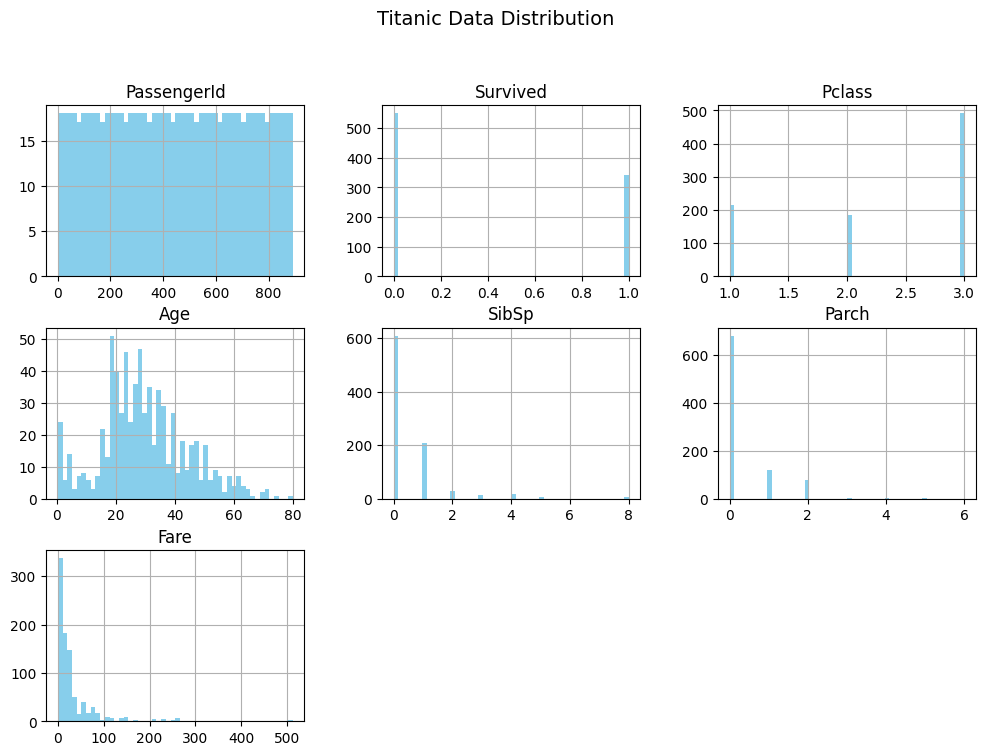

In [9]:
# Create histogram plot function to see numerical column distributions
train_data.hist(bins=50, figsize=(12,8), color='skyblue')
plt.suptitle("Titanic Data Distribution", fontsize=14, y=1)
plt.show()

As we can see from the distribution plot, most of the data is not normally distributed (right-skewed).

In [10]:
train_data.describe(include=object)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [14]:
def create_bar_chart_1(col_name, figsize=(5,5), title=None):
    # Group by column name and 'Survived' columns and count the number of passengers
    df_bar = train_data.groupby([col_name, 'Survived'])['PassengerId'].count().unstack()

    # Create a stacked bar chart to see total passengers combined with survival counts
    df_bar.plot(kind='bar', stacked=True, color=["orange", "skyblue"], figsize=(5,5))
    plt.xlabel(col_name)
    plt.ylabel('Number of Passengers')
    plt.title(title)
    plt.show()

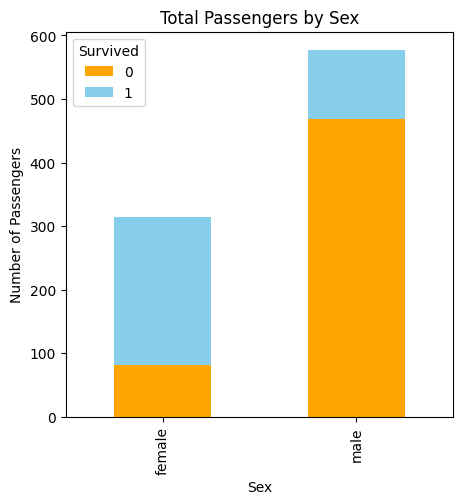

In [15]:
# Show bar chart of total passengers by sex
create_bar_chart_1(col_name="Sex", figsize=(5,5), title="Total Passengers by Sex")

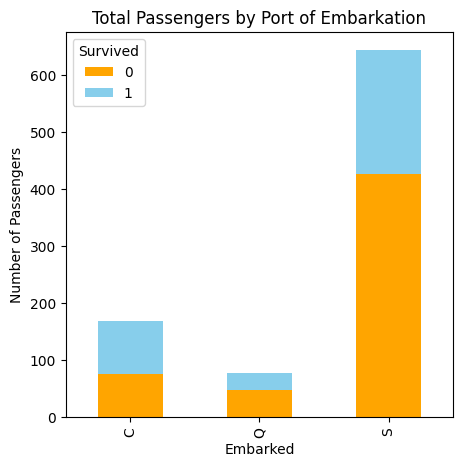

In [16]:
# Show bar chart of total passengers by port of embarkation
create_bar_chart_1(col_name="Embarked", figsize=(5,5), title="Total Passengers by Port of Embarkation")

By analysing two bar charts above, we can conclude:
1. In the disaster, most survivors are female even though the total passengers are dominated by men
2. Most casualties embarked from Southampton

In [10]:
# Function to check for percentage of men and women who survived
def survived_percentage(col_name,key):
    df = train_data.loc[train_data[col_name]==key]["Survived"]
    percentage = sum(df)/len(df)
    return round(percentage,2)*100

In [11]:
for sex in train_data["Sex"].unique().tolist():
    percentage = survived_percentage("Sex", sex)
    print(f"{percentage} {sex} passengers survived the disaster")

19.0 male passengers survived the disaster
74.0 female passengers survived the disaster


In [12]:
for embark in train_data["Embarked"].unique().tolist():
    if type(embark) == str:
        percentage = survived_percentage("Embarked", embark)
        print(f"{percentage} passengers from {embark} survived the disaster")

34.0 passengers from S survived the disaster
55.00000000000001 passengers from C survived the disaster
39.0 passengers from Q survived the disaster


# **3. Data Preparation**

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
# Check null values
df_null = pd.DataFrame({'Null Values' : train_data.isnull().sum(),
                        'Percentage Null Values' :
                         (train_data.isna().sum()) / (train_data.shape[0]) * (100)})
df_null = df_null[df_null['Null Values']>0]
df_null.sort_values('Percentage Null Values', ascending=False)

,Null Values,Percentage Null Values
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


In [15]:
# Delete cabin column due to many missing values
train_data.drop("Cabin", axis=1, inplace=True)

In [16]:
# Handle age column missing values with KNNImputer
# Initialize KNNImputer
# n_neighbors can be adjusted, here we set it as 3
imputer = KNNImputer(n_neighbors=3)

# Suppose 'Pclass', 'SibSp', 'Parch', 'Fare' are the features used to predict 'Age'
features = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']

# Perform imputation on features
train_data[features] = imputer.fit_transform(train_data[features])

In [17]:
# Handle embarked missing values by filling with mode
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

# **4. Modelling**

In [18]:
# Delete unused columns
df_model = train_data.drop(["PassengerId","Name", "Ticket"], axis=1)

In [19]:
# Create list of numerical and categorical columns for encoding and scaling
numerical_columns = df_model.describe().columns.tolist()
numerical_columns.remove("Survived")
categorical_columns = df_model.describe(include=object).columns.tolist()

In [20]:
# Define preprocessor for categorical features
categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')

# Define preprocessor for continuous features
numerical_preprocessor = RobustScaler()

# Combine the preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_preprocessor, categorical_columns),
    ('cont', numerical_preprocessor, numerical_columns)
])

# Define the classifiers you want to try
classifiers = [
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('LightGBM', LGBMClassifier())
]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [21]:
# Split data into features and target
X = df_model.drop('Survived', axis=1)  # Features
y = df_model['Survived']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 4.1. Train-Test Model

In [22]:
# Define a DataFrame to store results
results = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Recall', 'Precision',
                              'F1 Score', 'ROC AUC'])
for classifier_name, classifier in classifiers:
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('sampler', SMOTEENN()),
        ('classifier', classifier)
    ])

    # Fit and predict
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
     # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Append the results to the DataFrame
    results = results.append({
      'Classifier': classifier_name,
      'Accuracy': accuracy,
      'Recall': recall,
      'Precision': precision,
      'F1 Score': f1,
      'ROC AUC': roc_auc
    }, ignore_index=True)

results

/tmp/ipykernel_32/2477984178.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_32/2477984178.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_32/2477984178.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_32/2477984178.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


,Classifier,Accuracy,Recall,Precision,F1 Score,ROC AUC
0,Random Forest,0.809701,0.774775,0.767857,0.771300,0.875251
1,Gradient Boosting,0.817164,0.801802,0.767241,0.784141,0.866988
2,XGBoost,0.805970,0.774775,0.761062,0.767857,0.878895
3,LightGBM,0.820896,0.765766,0.794393,0.779817,0.876944


From the train-test modelling result above we can conclude that LightGBM is the best performing model across all scores, followed closely by XGBoost.

## 4.2. Cross Validation Model

In [23]:
# Perform cross validation
scoring_metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

# Define a list to store results
cross_val_list = []

for classifier_name, classifier in classifiers:# Calculate cross-validation scores for all specified metrics
    cv_scores = cross_validate(pipeline, X, y, cv=5, scoring=scoring_metrics)

    # Calculate mean scores for each metric
    mean_scores = {metric: np.mean(scores) for metric, scores in cv_scores.items() if 'test_' in metric}

    # Append the classifier name and mean scores to the results
    cross_val_list.append((classifier_name, mean_scores))

# Convert results to DataFrame
cross_val_results = pd.DataFrame(cross_val_list, columns=['Classifier', 'Scores'])

# Expand Scores column into separate columns for each score
cross_val_results = pd.concat([cross_val_results['Classifier'],
                   cross_val_results['Scores'].apply(pd.Series)], axis=1)

# Remove 'test_' prefix from column names
cross_val_results.columns = cross_val_results.columns.str.replace('test_', '')

cross_val_results

,Classifier,accuracy,recall,precision,f1,roc_auc
0,Random Forest,0.799134,0.777621,0.727770,0.747791,0.850148
1,Gradient Boosting,0.794658,0.815644,0.704360,0.753423,0.844853
2,XGBoost,0.807005,0.806863,0.725822,0.762538,0.848268
3,LightGBM,0.799140,0.789301,0.719128,0.750380,0.849317


From cross validation results above, we can conclude that the most consistent model is LightGBM with the best overall performance across all scores. We will use LightGBM as the final model for Hyperparameter tuning.

# **5. Hyperparameter Tuning**

In [24]:
classifier_name = 'LightGBM'
classifier = LGBMClassifier()
param_distribution = {
  'classifier__n_estimators': randint(50, 200),
  'classifier__learning_rate': uniform(0.01, 0.1),
  'classifier__max_depth': randint(3, 7),
  'classifier__num_leaves': randint(10, 50),
  'classifier__min_child_samples': randint(5, 20)
}

# Define a DataFrame to store results
tuning_results = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Recall', 
                                       'Precision', 'F1 Score', 'ROC AUC'])
tuning_scoring = {'AUC': 'roc_auc', 'F1': 'f1'}

random_search = RandomizedSearchCV(pipeline, param_distribution, n_iter=50,  
                                   cv=5, scoring=tuning_scoring, refit='F1')
random_search.fit(X_train, y_train)

# Get the best estimator
best_classifier = random_search.best_estimator_.named_steps['classifier']

# Get feature importances
importances = best_classifier.feature_importances_

# Get the feature names
feature_names = preprocessor.get_feature_names_out().tolist()

# Create a DataFrame to view the importances
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Save best parameter to file
with open("/kaggle/working/best_params_LGBM.pkl", 'wb') as f:
    pickle.dump(random_search.best_params_, f)

y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]

 # Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Append the results to the DataFrame
tuning_results = tuning_results.append({
  'Classifier': classifier_name,
  'Accuracy': accuracy,
  'Recall': recall,
  'Precision': precision,
  'F1 Score': f1,
  'ROC AUC': roc_auc
}, ignore_index=True)

/tmp/ipykernel_32/3365359995.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tuning_results = tuning_results.append({


In [25]:
tuning_results

,Classifier,Accuracy,Recall,Precision,F1 Score,ROC AUC
0,LightGBM,0.802239,0.72973,0.778846,0.753488,0.813336


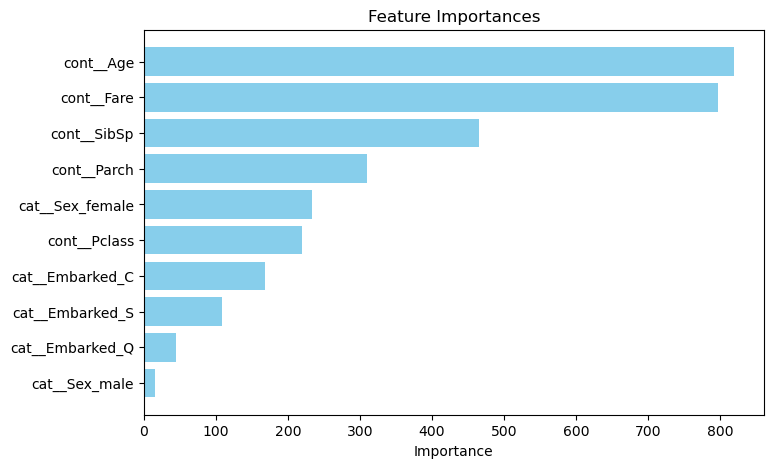

In [26]:
# Show the feature importances
plt.figure(figsize=(8, 5))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title("Feature Importances")
plt.gca().invert_yaxis()  # to have the feature with the highest importance on top
plt.show()

# **6. Testing Model**

In [27]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [28]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
